In [1]:
import gym
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T

import numpy as np
from tqdm import tqdm, trange

In [3]:
torch.random.manual_seed(3120)
np.random.seed(3120)

In [4]:
class PolicyNetwork(nn.Module):
    """
    A simple 2-layer MLP that outputs action probabilities given the current state
    """
    def __init__(self, hidden_dims):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(4,hidden_dims)
        self.fc2 = nn.Linear(hidden_dims,2)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.softmax(x,dim=1)

In [5]:
class Trainer():
    """
    Trainer class for our Policy network.
    """
    def __init__(self, hidden_dims=32, lr=1e-3, discounting_factor=0.99, mean_smoothing_factor=0.5):
        self.policy = PolicyNetwork(hidden_dims=hidden_dims)
        self.optim = torch.optim.Adam(self.policy.parameters(), lr=lr)
        self.env = gym.make('CartPole-v1').unwrapped
        self.discounting_factor = discounting_factor
        self.mean_smoothing_factor = mean_smoothing_factor
        self.action_dim = self.env.action_space.n
        self.eps = 1e-2
    
    def test_episode(self, show_display=False):
        self.policy.eval()
        with torch.no_grad():
            total_reward = 0
            state = torch.tensor(self.env.reset().astype(np.float32)).unsqueeze(0)
            if show_display:
                img = plt.imshow(self.env.render(mode='rgb_array')) # only call this once
            done = False
            ep_len=0
            while(done==False):
                if show_display:
                    img.set_data(self.env.render(mode='rgb_array')) # just update the data
                    display.display(plt.gcf())
                    display.clear_output(wait=True)
                ep_len+=1
                action_probs = self.policy(state).numpy().flatten()
                action = np.random.choice(np.arange(0,self.action_dim), p = action_probs)
                state,reward,done,_ = self.env.step(action)
                state = torch.tensor(state.astype(np.float32)).unsqueeze(0)
                total_reward+=reward
                if total_reward>5000:
                    print("Reached Max Reward Limit!")
                    break
            print("Reward received:", total_reward)
    
    def run_epsiode(self):
        """
        Run an episode in the environment using current policy and 
        store rewards received and log probabilities at each step
        """
        self.policy.train()
        state = torch.tensor(self.env.reset().astype(np.float32)).unsqueeze(0)
        self.saved_log_probs = []
        self.rewards = []
        # do not go into infinite while loop during training
        for step in range(2000):
            action_probs = (self.policy(state).squeeze()+self.eps)/(1+self.action_dim*self.eps)
            action = np.random.choice(np.arange(0,self.action_dim), p = action_probs.detach().cpu().numpy())
            self.saved_log_probs.append(torch.log(action_probs)[action])
            state, reward, done, _ = self.env.step(action)
            state = torch.tensor(state.astype(np.float32)).unsqueeze(0)
            self.rewards.append(reward)
            if done:
                break
        # if we hit the end of limit, we upweight the weight so as to not unnecessarily penalize the model
        if len(self.rewards)==2000:
            self.rewards[-1]=10
        return sum(self.rewards)
    
    def train_episode(self):
        """
        Run one episode and train policy network using REINFORCE
        using the discounted rewards and log probabilities of each action
        """
        train_ep_reward = self.run_epsiode()
        discounted_rewards = []
        running_reward = 0
        for r in self.rewards[::-1]:
            running_reward=r+self.discounting_factor*running_reward
            discounted_rewards.append(running_reward)
        discounted_rewards = discounted_rewards[::-1]
        
        discounted_rewards = torch.tensor(discounted_rewards)
        discounted_rewards = (discounted_rewards - discounted_rewards.mean())/ (discounted_rewards.std() + 1e-6)
        
        self.optim.zero_grad()
        policy_loss=0
        for log_prob,r in zip(self.saved_log_probs, discounted_rewards):
            policy_loss-=(log_prob*r).sum()
        policy_loss.backward()
        self.optim.step()
        return policy_loss.item(), train_ep_reward
            
        
    def train(self, training_episodes):
        loss_history = []
        reward_history = []
        epoch_iter = trange(training_episodes)
        epoch_iter.set_description_str("Episodes completed")
        running_loss = 0
        running_reward = 0
        for epoch in epoch_iter:
            self.eps = self.eps*0.9
            loss,reward = self.train_episode()
            
            # smooth out the loss and reward
            running_loss = self.mean_smoothing_factor*loss + (1-self.mean_smoothing_factor)*running_loss
            running_reward = self.mean_smoothing_factor*reward + (1-self.mean_smoothing_factor)*running_reward
            loss_history.append(running_loss)
            reward_history.append(running_reward)
            
            epoch_iter.set_postfix_str("Loss:{}, Reward:{}".format(round(running_loss,4), round(running_reward,4)))
        return loss_history, reward_history
    
    def save_model(self, filename="policy.pth"):
        torch.save(self.policy.state_dict(), filename)
    
    def load_model(self, filename="policy.pth"):
        self.policy.load_state_dict(torch.load(filename))

In [6]:
z = Trainer()

Let's test a random policy and see how much reward it gets

Reward received: 20.0


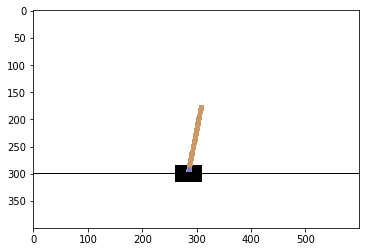

In [7]:
z.test_episode(show_display=True)

As the training progresses the reward per episode increases and training episodes start becoming longer. The longer episodes lead to slower progression of episodes.

In [8]:
loss,reward = z.train(training_episodes=1000)

Episodes completed: 100%|██████████| 1000/1000 [01:46<00:00,  9.39it/s, Loss:-4.8513, Reward:1669.8767]


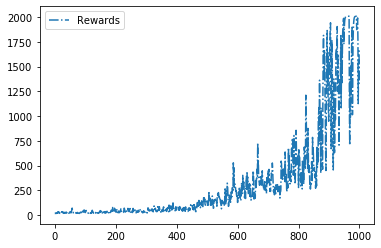

In [9]:
plt.plot(reward, "-.", label="Rewards")
plt.legend();

In [10]:
z.save_model()

Now, it is time to test the policy learned by our model. 

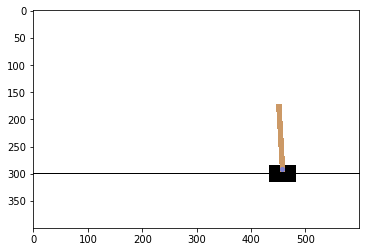

In [ ]:
z.test_episode(show_display=True)